# Deep Learning - Assignment 3 - Problem 1
### Ali Abbasi - 98105879

# Importing Libraries

In [77]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

import tqdm
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(24)
np.random.seed(24)

# Datasets and Dataloaders

In [39]:
import bisect

class Footwear(torch.utils.data.Dataset):
    def __init__(self, dataset_path, transform=None, shuffle=True):
        self.transform = transform
        self.target_names = os.listdir(dataset_path)
        self.name_to_label = {name: i for i, name in enumerate(self.target_names)}
        self.label_to_name = {i: name for name, i in self.name_to_label.items()}
        self.files = []
        self.labels = []
        for label, name in enumerate(self.target_names):
            for file in os.listdir(os.path.join(dataset_path, name)):
                self.files.append(os.path.join(dataset_path, name, file))
                self.labels.append(label)
        self.files = np.array(self.files)
        self.labels = np.array(self.labels)
        if shuffle:
            idx = np.random.permutation(len(self.files))
            self.files = self.files[idx]
            self.labels = self.labels[idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        assert item < self.__len__(), f"Index {item} is out of range"
        file = self.files[item]
        label = self.labels[item]
        imgage = Image.open(file)
        if self.transform is not None:
            imgage = self.transform(imgage)
        return imgage, label


In [52]:
dataset = Footwear("Shoe vs Sandal vs Boot Dataset", transform=T.Compose([T.ToTensor()]))
test_size = int(len(dataset) * 0.3)
train_size = len(dataset) - test_size
val_size = int(train_size * 0.2)
train_size = train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [51]:
train_size, val_size, test_size

(8400, 2100, 4500)

In [76]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(dataset.target_names)
image_shape

torch.Size([3, 102, 136])

In [55]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)
val_loader = DataLoader(val_set, 64, shuffle=True)

## Visualization

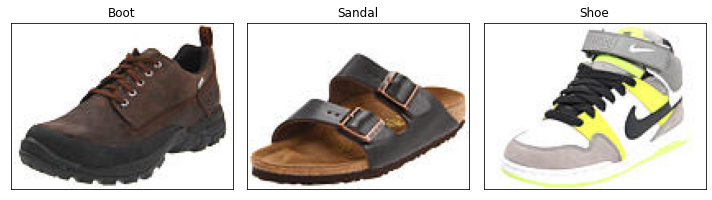

In [62]:
fig, axes = plt.subplots(1,3, figsize=(10, 10))
axes = axes.flat
topil = T.ToPILImage()
for j in range(len(dataset.target_names)):
    i = np.random.choice(np.where(np.array(dataset.labels) == j)[0])
    x, y = dataset[i]
    ax = axes[j]
    img = topil(x)
    ax.imshow(img)
    ax.set_title(dataset.label_to_name[y])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# MLP Model

In [65]:
from more_itertools import pairwise

class MLP_Model(nn.Module):
    
    def __init__(self, layers_inputs, dropout=False):
        super().__init__()
        layers_shape = list(pairwise(layers_inputs))
        layers = []
        for shape in layers_shape[:-1]:
            layers.append(nn.Linear(*shape))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(*layers_shape[-1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

In [67]:
layers_inputs = [input_dim, 512, 256, 128, 64, num_classes]
model = MLP_Model(layers_inputs, dropout=0.4)
model

MLP_Model(
  (layers): Sequential(
    (0): Linear(in_features=41616, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=64, out_features=3, bias=True)
  )
)

# Training Model

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [72]:
def one_epoch(model, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train', metrics=None):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    if train:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader)) as pbar:
        for i, (x, y) in pbar:
            if train:
                optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)

            total_loss += loss.item() * len(x)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}')
            if train:
                loss.backward()
                optimizer.step()

            y_pred = p.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def train_model(model, dataloaders, num_epochs, criterion, optimizer, model_name='pytroch-model', tensorboard_writer=None):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf
    for epoch in range(num_epochs):
        result = one_epoch(model, train_loader, criterion, optimizer, epoch, train=True, set_name='Train')
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(model, val_loader, criterion, epoch=epoch, train=False, set_name='Validation')
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print('\n', '-' * 60)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), f'{model_name}.pt')
        if tensorboard_writer:
            tensorboard_writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
            tensorboard_writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)

    tensorboard_writer.close()
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('loss history of training and val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and val sets')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(f'{model_name}.pt'))
    return model, min_val_loss

### Training:

In [ ]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
model = MLP_Model(layers_inputs, dropout=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/MLP')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

### MLP Results

In [73]:
average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

In [ ]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
test_results

In [ ]:
val_results = one_epoch(model, val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
val_results

In [ ]:
train_results = one_epoch(model, train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
train_results

### MLP Number of Parameters

In [74]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 21480579


### Tensorboard Results

In [ ]:
!tensorboard --logdir=runs/MLP

# Convolutional Model

In [122]:
class DropBlock2D(nn.Module):
    def __init__(self, block_size, drop_rate, batchwise=True):
        super(DropBlock2D, self).__init__()
        self.block_size = block_size
        self.droprate = drop_rate
        self.batchwise = batchwise
        self.gamma = None
        self.bernoulli = None

    def forward(self, x):
        if not self.training or self.droprate == 0:
            return x

        if self.gamma is None or self.bernoulli is None:
            self._create_params(x)

        if self.batchwise:
            mask = self.bernoulli.sample((1, *x.size()[1:])).to(x.device)
        else:
            mask = self.bernoulli.sample(x.size()).to(x.device)
        
        mask = F.max_pool2d(mask, self.block_size, stride=1, padding=self.block_size // 2)
        if self.block_size % 2 == 0:
            mask = mask[:, :, :-1, :-1]
        mask = 1 - mask

        normalize_scale = (mask.numel() / mask.float().sum().add(1e-6)).to(dtype=x.dtype)
        out = x * mask * normalize_scale
        return mask

    def _create_params(self, x):
        gamma = self.droprate / (self.block_size ** 2)
        bernoulli = torch.distributions.bernoulli.Bernoulli(gamma)

        self.gamma = gamma
        self.bernoulli = bernoulli

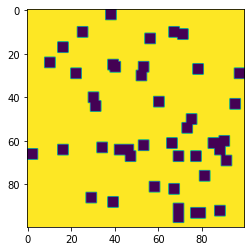

In [119]:
plt.imshow(DropBlock2D(5, 0.1)(torch.ones(1, 1, 100, 100)).squeeze().detach().numpy())
plt.show()

In [121]:
class Conv_Model(nn.Module):
    
    def __init__(self, input_shape, conv_layers, dropout_type=None, dropout_rate=None, batch_norm=False, kernel_factorization=False):
        super().__init__()
        layers = []
        for conv in conv_layers:
            if conv[0] == 'pool':
                layers.append(nn.MaxPool2d(conv[1:]))
                continue
            if kernel_factorization:
                conv_1 = conv.copy()
                conv_1[2] = (1, conv_1[2])
                layers.append(nn.Conv2d(*conv_1))
                conv_2 = conv
                conv_2[2] = (conv_2[2], 1)
                layers.append(nn.Conv2d(*conv_2))
            else:
                layers.append(nn.Conv2d(*conv))
            if batch_norm:
                layers.append(nn.BatchNorm2d(conv[1]))
            layers.append(nn.ReLU())
            if dropout_type == 'block':
                layers.append(DropBlock2D(5, dropout_rate))
            elif dropout_type == 'dropout':
                layers.append(nn.Dropout(dropout_rate))
        self.convs = nn.Sequential(*layers)
        with torch.no_grad():
            conv_output_shape = self.convs(torch.zeros(1, *input_shape)).shape[1:]
        self.classifier = nn.Linear(np.prod(conv_output_shape), num_classes)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
# conv layers: (in_channels, out_channels, kernel_size, stride, padding)
conv_layers = [(3, 32, 11, 3), (32, 64, 5), (64, 64, 3), (64, 64, 3)]
model = Conv_Model(image_shape, conv_layers, dropout_type='dropout', dropout_rate=0.4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/Conv1')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

In [ ]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
test_results

In [131]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of parameters: 286915


In [ ]:
!tensorboard --logdir=runs/Conv1

# Block Dropout

In [ ]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
conv_layers = [(3, 32, 11, 3), (32, 64, 5), (64, 64, 3), (64, 64, 3)]
model = Conv_Model(image_shape, conv_layers, dropout_type='block', dropout_rate=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/Conv2')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

In [ ]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
test_results

In [ ]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

In [ ]:
!tensorboard --logdir=runs/Conv2

# Kernel Factorization

In [ ]:
train_losses.clear()
val_losses.clear()
train_accuracies.clear()
val_accuracies.clear()

# Training config
lr = 0.001
conv_layers = [(3, 32, 11), (32, 64, 5), (64, 64, 3), (64, 64, 3)]
model = Conv_Model(image_shape, conv_layers, dropout_type='block', dropout_rate=0.4, kernel_factorization=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter('/runs/Conv3')
model, min_val_loss = train_model(model, [train_loader, val_loader], 25, criterion, optimizer, tensorboard_writer=writer)

In [ ]:
test_results = one_epoch(model, test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
test_results

In [ ]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

In [ ]:
!tensorboard --logdir=runs/Conv3